# Import Libraries 

In [ ]:
#import the necessary files and libraries 
#import the necessary libraries 
!pip install tweet-preprocessor
!pip install symspellpy
!pip install tqdm
!pip install zeugma
from zeugma.embeddings import EmbeddingTransformer
from sklearn.linear_model import LogisticRegression
from nltk.tokenize import TweetTokenizer
from symspellpy.symspellpy import SymSpell
from bs4 import BeautifulSoup
from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
import preprocessor as p
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import lxml
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, accuracy_score
from keras.utils import to_categorical
import tensorflow as tf 
import io
import re
import string
import nltk
import pkg_resources
import ast 
import pickle
import gensim
import logging
import nltk.data
nltk.download('punkt')
nltk.download
nltk.download('wordnet')
nltk.download('stopwords')

     |████████████████████████████████| 2.6MB 8.7MB/s 
  Created wheel for zeugma: filename=zeugma-0.48-cp36-none-any.whl size=8777 sha256=f9a7e1e9ed0322c43c35cfed746821ea8b42041c90c7bf985cb19bb5c962fd53
  Stored in directory: /root/.cache/pip/wheels/6a/b5/bc/5183ac478b0071d04d3ed0c0dd4a43db94c5c8ffb317b5eb53
Successfully built zeugma
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Evaluation function 
def evaluate_on_training_set(y_test, y_pred):
  # Calculate AUC
  print("AUC is: ", roc_auc_score(y_test, y_pred))
  
  # print out recall and precision
  print(classification_report(y_test, y_pred))
  
  # print out confusion matrix
  print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))

  # # calculate points for ROC curve
  fpr, tpr, thresholds = roc_curve(y_test, y_pred)
  
  # Plot ROC curve
  plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc_score(y_test, y_pred))
  plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate or (1 - Specifity)')
  plt.ylabel('True Positive Rate or (Sensitivity)')
  plt.title('Receiver Operating Characteristic')

In [ ]:
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
  lb = LabelBinarizer()
  lb.fit(y_test)
  y_test = lb.transform(y_test)
  y_pred = lb.transform(y_pred)
  return roc_auc_score(y_test, y_pred, average=average)

# Data Cleaning Final

## Load the DataFrames

In [ ]:
#read the files into their respective dataframes 
labela_df = pd.read_csv('/content/drive/My Drive/CDS_Project/OLIDv1/labels-levela.csv', header = None)
labelb_df = pd.read_csv('/content/drive/My Drive/CDS_Project/OLIDv1/labels-levelb.csv', header = None)
labelc_df = pd.read_csv('/content/drive/My Drive/CDS_Project/OLIDv1/labels-levelc.csv', header = None)
testa_df = pd.read_csv('/content/drive/My Drive/CDS_Project/OLIDv1/testset-levela.tsv', sep = '\t')
testb_df = pd.read_csv('/content/drive/My Drive/CDS_Project/OLIDv1/testset-levelb.tsv', sep = '\t')
testc_df = pd.read_csv('/content/drive/My Drive/CDS_Project/OLIDv1/testset-levelc.tsv', sep = '\t')
train_df = pd.read_csv('/content/drive/My Drive/CDS_Project/OLIDv1/olid-training-v1.0.tsv', sep = '\t')
experiment_df = pd.read_excel('/content/drive/My Drive/CDS_Project/OLIDv1/Data/PublicData.xlsx')

In [ ]:
#Clean the experimental labels 
experiment_df['subtask_a'] = experiment_df['subtask_a'].replace('OFF ', 'OFF')
experiment_df['subtask_b'] = experiment_df['subtask_b'].replace('OFF ', 'OFF')
experiment_df['subtask_c'] = experiment_df['subtask_c'].replace('OFF ', 'OFF')
experiment_df['subtask_a'].unique(),experiment_df['subtask_b'].unique(), experiment_df['subtask_c'].unique() 

(array(['OFF', 'NOT'], dtype=object),
 array(['TIN', nan, 'UNT'], dtype=object),
 array(['IND', 'GRP', 'OTH', nan], dtype=object))

In [ ]:
#Split the experiment data into A, B and C
experiment_a_df = experiment_df[['tweet', 'subtask_a']]
experiment_b_df = experiment_df[['tweet', 'subtask_b']]
experiment_c_df = experiment_df[['tweet', 'subtask_c']]
experiment_a_df.head()

,tweet,subtask_a
0,RT @iSellGreenCards: 1st RT @MsSashaBelle: Sho...,OFF
1,@40oz_VAN IYCMI. I can't get any work done if ...,OFF
2,&#8220;@lildebo2391: He too rich to let that b...,OFF
3,Really Barnicle? OJ or Anthony Weiner? MJ is a...,OFF
4,RT @GabrielaAngela4: That hoe wanta 6/6.,OFF


In [ ]:
#Merge the label dataset with the test data set, so only Test data set needed

testa_df['subtask_a'] = labela_df[1]
testb_df['subtask_b'] = labelb_df[1]
testc_df['subtask_c'] = labelc_df[1]
testc_df.head()

,id,tweet,subtask_c
0,15923,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...,OTH
1,60133,#NoPasaran: Unity demo to oppose the far-right...,GRP
2,83681,. . . What the fuck did he do this time?,IND
3,65507,@USER Do you get the feeling he is kissing @US...,OTH
4,34263,#StopKavanaugh he is liar like the rest of the...,IND


In [ ]:
#View the training data set
train_df.head()

,id,tweet,subtask_a,subtask_b,subtask_c
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN


## Cleaning the Tweets

The training and test data are in 2 separate files, so a function has been written to to tidy the text up and return a column of cleaned tweets

* remove URLs, Hashtags, Mentions, Reserved Words (RT, FAV), Emojis
* Change text to lowercase 
* Handle Apostrophe (e.g. aren't -> are not)
* Remove punctuations
* Remove numbers 
* Segment the words (fix the spelling) 
* Lemmatization and Tokenization
* Remove Stop Words (with Blacklist and Whitelist words)

### Cleaning Function

In [ ]:
#list of contractions to remove later 
contractions = {
"ain't": "am not / are not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is",
"i'd": "I had / I would",
"i'd've": "I would have",
"i'll": "I shall / I will",
"i'll've": "I shall have / I will have",
"i'm": "I am",
"i've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

In [ ]:
#Setting up SymSpell to segment words
sym_spell = SymSpell(max_dictionary_edit_distance=0, prefix_length=7)
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt")
# term_index is the column of the term and count_index is the column of the term frequency
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)


True

In [ ]:
#Setting up Lematizer, Tokenizer
lemmatizer = nltk.stem.WordNetLemmatizer()
w_tokenizer = TweetTokenizer()

In [ ]:
#Removes specially chosen stop words
def cleaner(row, contractions, blacklist, whitelist):
  '''
  Blacklist: Words that are not in stop words but we will be removing 
  Whitelist: Words that are in the stop words but we will be keeping
  '''
  #remove URLs, Hashtags, Mentions, Reserved Words (RT, FAV), Emojis
  row = p.clean(row)
  #lower the text 
  row = row.lower()
  #Apostrophe Handling
  for word in row.split():
    if word in contractions: 
      row = row.replace(word, contractions[word.lower()])
  #remove punctuations
  row  = "".join([char for char in row if char not in string.punctuation])
  row = re.sub('[0-9]+', '', row, flags=re.MULTILINE)
  #remove numbers 
  row = re.sub(r'\d+', '', row, flags=re.MULTILINE)
  #Segment the words 
  try:
    row = (sym_spell.word_segmentation(row)).corrected_string
  except: 
    pass
  #Lemmatization and Tokenization
  row = [(lemmatizer.lemmatize(w)) for w in w_tokenizer.tokenize((row))]
  #Stopwords 
  all_stopwords = stopwords.words('english')
  all_stopwords.extend(blacklist)
  all_stopwords = set(all_stopwords)- set(whitelist)
  row = [word for word in row if word not in all_stopwords]
  return row

In [ ]:
tqdm.pandas()
#List of stopwords that want to remove in addition to the ones in stopwords corpus
badboy_list = ['url', 'ha']
#List of stopwords that we would like to keep 
goodboy_list = ['i', 'he', 'she', 'it', 'him', 'her', 'we', 'you', 'they', 'us', 'them' ]
#Apply modified clean tweet to the training data
train_df['clean_tweet'] = train_df['tweet'].progress_apply(lambda x: cleaner(x, contractions, badboy_list, goodboy_list))
#Apply modified clean tweet to the test data
testc_df['clean_tweet'] = testc_df['tweet'].progress_apply(lambda x: cleaner(x, contractions, badboy_list, goodboy_list))
testb_df['clean_tweet'] = testb_df['tweet'].progress_apply(lambda x: cleaner(x, contractions, badboy_list, goodboy_list))
testa_df['clean_tweet'] = testa_df['tweet'].progress_apply(lambda x: cleaner(x, contractions, badboy_list, goodboy_list))
#Apply modified cleaen tweet to the experimental data 
experiment_a_df['clean_tweet'] = experiment_a_df['tweet'].progress_apply(lambda x: cleaner(x, contractions, badboy_list, goodboy_list))
experiment_b_df['clean_tweet'] = experiment_b_df['tweet'].progress_apply(lambda x: cleaner(x, contractions, badboy_list, goodboy_list))
experiment_c_df['clean_tweet'] = experiment_c_df['tweet'].progress_apply(lambda x: cleaner(x, contractions, badboy_list, goodboy_list))

100%|██████████| 200/200 [00:01<00:00, 170.88it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
100%|██████████| 200/200 [00:01<00:00, 170.23it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
100%|██████████| 200/200 [00:01<00:00, 170.41it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on

In [ ]:
experiment_a_df.head()

,tweet,subtask_a,clean_tweet
0,RT @iSellGreenCards: 1st RT @MsSashaBelle: Sho...,OFF,"[st, rt, show, proof, i, sold, pussy, I, shall..."
1,@40oz_VAN IYCMI. I can't get any work done if ...,OFF,"[iycmi, i, get, work, done, you, keep, show, b..."
2,&#8220;@lildebo2391: He too rich to let that b...,OFF,"[he, rich, let, bitch, get, him, mad, like, ni..."
3,Really Barnicle? OJ or Anthony Weiner? MJ is a...,OFF,"[really, barn, i, cleo, j, anthony, we, er, mj..."
4,RT @GabrielaAngela4: That hoe wanta 6/6.,OFF,"[hoe, want]"


In [ ]:
#Train Dataframe for each of the subsets  
train_df_a = train_df.dropna(subset=['subtask_a'])
train_df_a = train_df_a.drop(columns = ['subtask_b', 'subtask_c'])
train_df_b = train_df.dropna(subset=['subtask_b'])
train_df_b = train_df_b.drop(columns = ['subtask_a', 'subtask_c'])
train_df_c = train_df.dropna(subset=['subtask_c'])
train_df_c = train_df_c.drop(columns = ['subtask_a', 'subtask_b'])
experiment_a_df = experiment_a_df.dropna(subset=['subtask_a']) 
experiment_b_df = experiment_b_df.dropna(subset=['subtask_b'])
experiment_c_df = experiment_c_df.dropna(subset=['subtask_c'])

In [ ]:
experiment_a_df['subtask_a'].unique(), experiment_b_df['subtask_b'].unique(), experiment_c_df['subtask_c'].unique()

(array(['OFF', 'NOT'], dtype=object),
 array(['TIN', 'UNT'], dtype=object),
 array(['IND', 'GRP', 'OTH'], dtype=object))

Key Dataframes 

In [ ]:
#Split the data into X and Y 
#Split the data into X and Y
a_trainX_df = train_df_a['clean_tweet']
a_trainY_df = train_df_a['subtask_a'] 
a_testX_df = testa_df['clean_tweet'] 
a_testY_df = testa_df['subtask_a'] 
a_experimentX_df = experiment_a_df['clean_tweet']
a_experimentY_df = experiment_a_df['subtask_a']

b_trainX_df = train_df_b['clean_tweet']
b_trainY_df = train_df_b['subtask_b'] 
b_testX_df = testb_df['clean_tweet'] 
b_testY_df = testb_df['subtask_b'] 
b_experimentX_df = experiment_b_df['clean_tweet']
b_experimentY_df = experiment_b_df['subtask_b']


c_trainX_df = train_df_c['clean_tweet']
c_trainY_df = train_df_c['subtask_c'] 
c_testX_df = testc_df['clean_tweet'] 
c_testY_df = testc_df['subtask_c'] 
c_experimentX_df = experiment_c_df['clean_tweet']
c_experimentY_df = experiment_c_df['subtask_c']

## Vectorizing the Tweets

In [ ]:
#Convert list to string
train_df['clean_tweet_str'] = train_df['clean_tweet'].apply(lambda x: ' '.join([str(elem) for elem in x]))

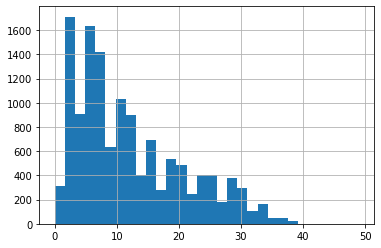

In [ ]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_df['clean_tweet_str']]
pd.Series(seq_len).hist(bins = 30)

In [ ]:
#Count the number of unique words
from collections import Counter
results = Counter()
train_df['clean_tweet_str'].str.lower().str.split().apply(results.update)
print(len(results.keys()))

13828


In [ ]:
#Vectorizing the training data
#https://stackoverflow.com/questions/45735070/keras-text-preprocessing-saving-tokenizer-object-to-file-for-scoring
def vectorizing(trainX_df, testX_df, experiment_dfX, category):
  MAX_NUM_WORDS = 13828 # Parameter indicating the number of words we'll put in the dictionary
  MAX_SEQUENCE_LENGTH = 40 # Maximum number of words in a sequence
  tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
  tokenizer.fit_on_texts(trainX_df)
  token_file_name = 'tokenizer_' + category + '.pickle'
  with open(token_file_name, 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
  #Tokenize the training and test data set
  trainX_seq = tokenizer.texts_to_sequences(trainX_df)
  testX_seq = tokenizer.texts_to_sequences(testX_df)
  experimentX_seq = tokenizer.texts_to_sequences(experiment_dfX)

  word_index = tokenizer.word_index
  print('Found %s unique tokens.' % len(word_index))

  #Padding the sequence 
  trainX_seq_trunc = pad_sequences(trainX_seq, maxlen=MAX_SEQUENCE_LENGTH)
  testX_seq_trunc = pad_sequences(testX_seq, maxlen=MAX_SEQUENCE_LENGTH)
  experimentX_seq_trunc = pad_sequences(experimentX_seq, maxlen = MAX_SEQUENCE_LENGTH)
  return trainX_seq_trunc, testX_seq_trunc, experimentX_seq_trunc, word_index

In [ ]:
a_trainX_df.head()

0                   [she, ask, native, american, take]
1                               [go, home, you, drunk]
2    [amazon, investigating, chinese, employee, sel...
3            [someone, vet, ken, piece, shit, volcano]
4    [obama, wanted, liberal, amp, illegals, move, ...
Name: clean_tweet, dtype: object

In [ ]:
#Generate vectorized matrix for A B and C
vec_a_trainX_df, vec_a_testX_df, vec_a_exp_df, word_index_a = vectorizing(a_trainX_df, a_testX_df, a_experimentX_df, 'a')
vec_b_trainX_df, vec_b_testX_df, vec_b_exp_df, word_index_b = vectorizing(b_trainX_df, b_testX_df, b_experimentX_df,'b')
vec_c_trainX_df, vec_c_testX_df, vec_c_exp_df, word_index_c = vectorizing(c_trainX_df, c_testX_df, c_experimentX_df, 'c')

Found 13828 unique tokens.
Found 8208 unique tokens.
Found 7751 unique tokens.


In [ ]:
a_experimentY_df.unique()

array(['OFF', 'NOT'], dtype=object)

In [ ]:
#Convert the target classes to categoricial  
le = LabelEncoder()
ie_a_trainY_df = le.fit_transform(a_trainY_df)
print(le.classes_)
ie_a_testY_df = le.transform(a_testY_df)
ie_a_exp_y_df = le.transform(a_experimentY_df)
ie_b_trainY_df = le.fit_transform(b_trainY_df)
print(le.classes_)
ie_b_testY_df = le.transform(b_testY_df)
ie_b_exp_y_df = le.transform(b_experimentY_df)
ie_c_trainY_df = le.fit_transform(c_trainY_df)
print(le.classes_)
ie_c_testY_df = le.transform(c_testY_df)
ie_c_exp_y_df = le.transform(c_experimentY_df)

#Convert to One Hot Encoding
oh_a_trainY_df = to_categorical(ie_a_trainY_df)
oh_a_testY_df = to_categorical(ie_a_testY_df)
oh_a_exp_y_df = to_categorical(ie_a_exp_y_df)
oh_b_trainY_df = to_categorical(ie_b_trainY_df)
oh_b_testY_df = to_categorical(ie_b_testY_df)
oh_b_exp_y_df = to_categorical(ie_b_exp_y_df)
oh_c_trainY_df = to_categorical(ie_c_trainY_df)
oh_c_testY_df = to_categorical(ie_c_testY_df)
oh_c_exp_y_df = to_categorical(ie_c_exp_y_df)

['NOT' 'OFF']
['TIN' 'UNT']
['GRP' 'IND' 'OTH']


In [ ]:
le.classes_

array(['GRP', 'IND', 'OTH'], dtype=object)

In [ ]:
oh_a_trainY_df.shape,ie_a_trainY_df.shape

((13240, 2), (13240,))

### Splitting of Validation Data
* For one hot encoding
* For integer encoding

In [ ]:
#Allocate 10% of the training data for validation 
oh_a_trainX_df, oh_a_validX_df, oh_a_trainY_df, oh_a_validY_df = train_test_split(vec_a_trainX_df, oh_a_trainY_df, test_size = 0.1, random_state = 37)
oh_b_trainX_df, oh_b_validX_df, oh_b_trainY_df, oh_b_validY_df = train_test_split(vec_b_trainX_df, oh_b_trainY_df, test_size = 0.1, random_state = 37)
oh_c_trainX_df, oh_c_validX_df, oh_c_trainY_df, oh_c_validY_df = train_test_split(vec_c_trainX_df, oh_c_trainY_df, test_size = 0.1, random_state = 37)

#For Integer Encoding 
le_a_trainX_df, le_a_validX_df, le_a_trainY_df, le_a_validY_df = train_test_split(vec_a_trainX_df, ie_a_trainY_df, test_size = 0.1, random_state = 37)
le_b_trainX_df, le_b_validX_df, le_b_trainY_df, le_b_validY_df = train_test_split(vec_b_trainX_df, ie_b_trainY_df, test_size = 0.1, random_state = 37)
le_c_trainX_df, le_c_validX_df, le_c_trainY_df, le_c_validY_df = train_test_split(vec_c_trainX_df, ie_c_trainY_df, test_size = 0.1, random_state = 37)

In [ ]:
le_a_trainX_df

array([[   0,    0,    0, ..., 3382, 4711,  286],
       [   0,    0,    0, ...,   68,  130, 4400],
       [   0,    0,    0, ...,   37, 1965,  826],
       ...,
       [   0,    0,    0, ...,  971,   24,    3],
       [   0,    0,    0, ..., 4466, 3463,   43],
       [   0,    0,    0, ...,    0,   77, 3143]], dtype=int32)

# GloVe
* For Neural Network 
* For statistical model

## For STATS Model

In [ ]:
#convert the training data to string
a_trainX_str = a_trainX_df.apply(', '.join)
a_testX_str = a_testX_df.apply(', ' .join)
a_expX_str = a_experimentX_df.apply(',' .join)
b_trainX_str = b_trainX_df.apply(', '.join)
b_testX_str = b_testX_df.apply(', '.join)
b_expX_str = b_experimentX_df.apply(',' .join)
c_trainX_str = c_trainX_df.apply(', '.join)
c_testX_str = c_testX_df.apply(', '.join)
c_expX_str = c_experimentX_df.apply(',' .join)

In [ ]:
#Download the embedding transformer 
## TAKES LONG
glove = EmbeddingTransformer('glove-twitter-200')


[==================================================] 100.0% 758.5/758.5MB downloaded


In [ ]:
#Embed the training data 
a_trainX_em = glove.transform(a_trainX_str)
a_testX_em = glove.transform(a_testX_str)
a_expX_em = glove.transform(a_expX_str)
b_trainX_em = glove.transform(b_trainX_str)
b_testX_em = glove.transform(b_testX_str)
b_expX_em = glove.transform(b_expX_str)
c_trainX_em = glove.transform(c_trainX_str)
c_testX_em = glove.transform(c_testX_str)
c_expX_em = glove.transform(c_expX_str)

In [ ]:
b_trainX_em.shape, ie_b_trainY_df.shape, b_testX_df.shape, b_testX_em.shape

((4400, 200), (4400,), (240,), (240, 200))

In [ ]:
# Create Validation Split
a_trainX_em, a_validX_em, a_trainY_em, a_validY_em = train_test_split(a_trainX_em, ie_a_trainY_df, test_size=0.1, random_state=37)
b_trainX_em, b_validX_em, b_trainY_em, b_validY_em = train_test_split(b_trainX_em, ie_b_trainY_df, test_size=0.1, random_state=37)
c_trainX_em, c_validX_em, c_trainY_em, c_validY_em = train_test_split(c_trainX_em, ie_c_trainY_df, test_size=0.1, random_state=37)

### Test the Model's Performance 

AUC is:  0.5877262443438914
              precision    recall  f1-score   support

           0       0.73      0.65      0.69       884
           1       0.43      0.53      0.47       440

    accuracy                           0.61      1324
   macro avg       0.58      0.59      0.58      1324
weighted avg       0.63      0.61      0.62      1324

Confusion Matrix: 
 [[575 309]
 [209 231]]


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


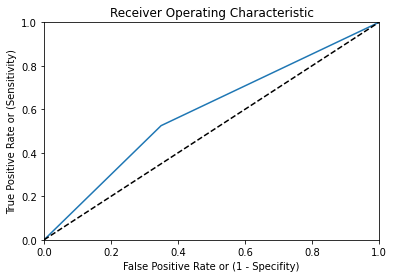

In [ ]:
# Balanced Weights
# LOGISTIC REGRESSION

model = LogisticRegression(max_iter=100000, class_weight='balanced', solver='newton-cg')
model.fit(a_trainX_em, a_trainY_em)

y_pred = model.predict(a_validX_em)

evaluate_on_training_set(a_validY_em, y_pred)

AUC is:  0.5445797329143756
              precision    recall  f1-score   support

           0       0.92      0.64      0.76       402
           1       0.11      0.45      0.17        38

    accuracy                           0.62       440
   macro avg       0.52      0.54      0.46       440
weighted avg       0.85      0.62      0.71       440

Confusion Matrix: 
 [[258 144]
 [ 21  17]]


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


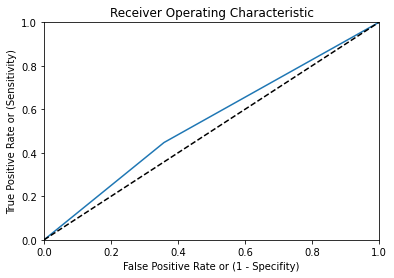

In [ ]:
# Balanced Weights
# LOGISTIC REGRESSION

model = LogisticRegression(max_iter=100000, class_weight='balanced', solver='newton-cg')
model.fit(b_trainX_em, b_trainY_em)

y_pred = model.predict(b_validX_em)

evaluate_on_training_set(b_validY_em, y_pred)

In [ ]:
# Balanced Weights
# LOGISTIC REGRESSION
from sklearn.metrics import classification_report, confusion_matrix

model = LogisticRegression(max_iter=100000, class_weight='balanced', solver='newton-cg', multi_class='ovr')
model.fit(c_trainX_em, c_trainY_em)

y_pred = model.predict(c_validX_em)

classification_report = classification_report(c_validY_em, y_pred)

print('\n Accuracy: ', accuracy_score(c_validY_em, y_pred))
print('\nClassification Report')
print('======================================================')
print('\n', classification_report)

print(f"AUC score:{multiclass_roc_auc_score(c_validY_em, y_pred)}")

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')



 Accuracy:  0.47164948453608246

Classification Report

               precision    recall  f1-score   support

           0       0.33      0.38      0.35        97
           1       0.75      0.51      0.60       261
           2       0.14      0.47      0.22        30

    accuracy                           0.47       388
   macro avg       0.41      0.45      0.39       388
weighted avg       0.59      0.47      0.51       388

AUC score:0.5839535211704997


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


# Data Cleaning Init

## Load the DataFrames

In [ ]:
#read the files into their respective dataframes 
labela_df = pd.read_csv('/content/drive/My Drive/CDS_Project/OLIDv1/labels-levela.csv', header = None)
labelb_df = pd.read_csv('/content/drive/My Drive/CDS_Project/OLIDv1/labels-levelb.csv', header = None)
labelc_df = pd.read_csv('/content/drive/My Drive/CDS_Project/OLIDv1/labels-levelc.csv', header = None)
testa_df = pd.read_csv('/content/drive/My Drive/CDS_Project/OLIDv1/testset-levela.tsv', sep = '\t')
testb_df = pd.read_csv('/content/drive/My Drive/CDS_Project/OLIDv1/testset-levelb.tsv', sep = '\t')
testc_df = pd.read_csv('/content/drive/My Drive/CDS_Project/OLIDv1/testset-levelc.tsv', sep = '\t')
train_df = pd.read_csv('/content/drive/My Drive/CDS_Project/OLIDv1/olid-training-v1.0.tsv', sep = '\t')
experiment_df = pd.read_excel('/content/drive/My Drive/CDS_Project/OLIDv1/Data/PublicData.xlsx')

In [ ]:
#Clean the experimental labels 
experiment_df['subtask_a'] = experiment_df['subtask_a'].replace('OFF ', 'OFF')
experiment_df['subtask_b'] = experiment_df['subtask_b'].replace('OFF ', 'OFF')
experiment_df['subtask_c'] = experiment_df['subtask_c'].replace('OFF ', 'OFF')
experiment_df['subtask_a'].unique(),experiment_df['subtask_b'].unique(), experiment_df['subtask_c'].unique() 

(array(['OFF', 'NOT'], dtype=object),
 array(['TIN', nan, 'UNT'], dtype=object),
 array(['IND', 'GRP', 'OTH', nan], dtype=object))

In [ ]:
#Split the experiment data into A, B and C
experiment_a_df = experiment_df[['tweet', 'subtask_a']]
experiment_b_df = experiment_df[['tweet', 'subtask_b']]
experiment_c_df = experiment_df[['tweet', 'subtask_c']]
experiment_a_df.head()

,tweet,subtask_a
0,RT @iSellGreenCards: 1st RT @MsSashaBelle: Sho...,OFF
1,@40oz_VAN IYCMI. I can't get any work done if ...,OFF
2,&#8220;@lildebo2391: He too rich to let that b...,OFF
3,Really Barnicle? OJ or Anthony Weiner? MJ is a...,OFF
4,RT @GabrielaAngela4: That hoe wanta 6/6.,OFF


In [ ]:
#Merge the label dataset with the test data set, so only Test data set needed

testa_df['subtask_a'] = labela_df[1]
testb_df['subtask_b'] = labelb_df[1]
testc_df['subtask_c'] = labelc_df[1]
testc_df.head()

,id,tweet,subtask_c
0,15923,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...,OTH
1,60133,#NoPasaran: Unity demo to oppose the far-right...,GRP
2,83681,. . . What the fuck did he do this time?,IND
3,65507,@USER Do you get the feeling he is kissing @US...,OTH
4,34263,#StopKavanaugh he is liar like the rest of the...,IND


In [ ]:
#View the training data set
train_df.head()

,id,tweet,subtask_a,subtask_b,subtask_c
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN


## Cleaning the Tweets

The training and test data are in 2 separate files, so a function has been written to to tidy the text up and return a column of cleaned tweets

* remove URLs, Hashtags, Mentions, Reserved Words (RT, FAV), Emojis
* Change text to lowercase 
* Handle Apostrophe (e.g. aren't -> are not)
* Remove punctuations
* Remove numbers 
* Segment the words (fix the spelling) 
* Lemmatization and Tokenization
* Remove Stop Words (with Blacklist and Whitelist words)

### Cleaning Function

In [ ]:
#list of contractions to remove later 
contractions = {
"ain't": "am not / are not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is",
"i'd": "I had / I would",
"i'd've": "I would have",
"i'll": "I shall / I will",
"i'll've": "I shall have / I will have",
"i'm": "I am",
"i've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

In [ ]:
#Setting up SymSpell to segment words
sym_spell = SymSpell(max_dictionary_edit_distance=0, prefix_length=7)
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt")
# term_index is the column of the term and count_index is the column of the term frequency
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)


True

In [ ]:
#Setting up Lematizer, Tokenizer
lemmatizer = nltk.stem.WordNetLemmatizer()
w_tokenizer = TweetTokenizer()

In [ ]:
#Removes specially chosen stop words
def cleaner(row, contractions, blacklist, whitelist):
  '''
  Blacklist: Words that are not in stop words but we will be removing 
  Whitelist: Words that are in the stop words but we will be keeping
  '''
  #remove URLs, Hashtags, Mentions, Reserved Words (RT, FAV), Emojis
  row = p.clean(row)
  #lower the text 
  row = row.lower()
  #Apostrophe Handling
  for word in row.split():
    if word in contractions: 
      row = row.replace(word, contractions[word.lower()])
  #remove punctuations
  row  = "".join([char for char in row if char not in string.punctuation])
  row = re.sub('[0-9]+', '', row, flags=re.MULTILINE)
  #remove numbers 
  row = re.sub(r'\d+', '', row, flags=re.MULTILINE)
  #Segment the words 
  try:
    row = (sym_spell.word_segmentation(row)).corrected_string
  except: 
    pass
  #Lemmatization and Tokenization
  row = [(lemmatizer.lemmatize(w)) for w in w_tokenizer.tokenize((row))]
  #Stopwords 
  all_stopwords = stopwords.words('english')
  all_stopwords.extend(blacklist)
  all_stopwords = set(all_stopwords)- set(whitelist)
  row = [word for word in row if word not in all_stopwords]
  return row

In [ ]:
tqdm.pandas()
#List of stopwords that want to remove in addition to the ones in stopwords corpus
badboy_list = []
#List of stopwords that we would like to keep 
goodboy_list = [ ]
#Apply modified clean tweet to the training data
train_df['clean_tweet'] = train_df['tweet'].progress_apply(lambda x: cleaner(x, contractions, badboy_list, goodboy_list))
#Apply modified clean tweet to the test data
testc_df['clean_tweet'] = testc_df['tweet'].progress_apply(lambda x: cleaner(x, contractions, badboy_list, goodboy_list))
testb_df['clean_tweet'] = testb_df['tweet'].progress_apply(lambda x: cleaner(x, contractions, badboy_list, goodboy_list))
testa_df['clean_tweet'] = testa_df['tweet'].progress_apply(lambda x: cleaner(x, contractions, badboy_list, goodboy_list))
#Apply modified cleaen tweet to the experimental data 
experiment_a_df['clean_tweet'] = experiment_a_df['tweet'].progress_apply(lambda x: cleaner(x, contractions, badboy_list, goodboy_list))
experiment_b_df['clean_tweet'] = experiment_b_df['tweet'].progress_apply(lambda x: cleaner(x, contractions, badboy_list, goodboy_list))
experiment_c_df['clean_tweet'] = experiment_c_df['tweet'].progress_apply(lambda x: cleaner(x, contractions, badboy_list, goodboy_list))

100%|██████████| 200/200 [00:01<00:00, 180.10it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
100%|██████████| 200/200 [00:01<00:00, 181.12it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
100%|██████████| 200/200 [00:01<00:00, 181.02it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on

In [ ]:
experiment_a_df.head()

,tweet,subtask_a,clean_tweet
0,RT @iSellGreenCards: 1st RT @MsSashaBelle: Sho...,OFF,"[st, rt, show, proof, sold, pussy, I, shall, I..."
1,@40oz_VAN IYCMI. I can't get any work done if ...,OFF,"[iycmi, get, work, done, keep, show, bitch]"
2,&#8220;@lildebo2391: He too rich to let that b...,OFF,"[rich, let, bitch, get, mad, like, nigga, think]"
3,Really Barnicle? OJ or Anthony Weiner? MJ is a...,OFF,"[really, barn, cleo, j, anthony, er, mj, clown..."
4,RT @GabrielaAngela4: That hoe wanta 6/6.,OFF,"[hoe, want]"


In [ ]:
#Train Dataframe for each of the subsets  
train_df_a = train_df.dropna(subset=['subtask_a'])
train_df_a = train_df_a.drop(columns = ['subtask_b', 'subtask_c'])
train_df_b = train_df.dropna(subset=['subtask_b'])
train_df_b = train_df_b.drop(columns = ['subtask_a', 'subtask_c'])
train_df_c = train_df.dropna(subset=['subtask_c'])
train_df_c = train_df_c.drop(columns = ['subtask_a', 'subtask_b'])
experiment_a_df = experiment_a_df.dropna(subset=['subtask_a']) 
experiment_b_df = experiment_b_df.dropna(subset=['subtask_b'])
experiment_c_df = experiment_c_df.dropna(subset=['subtask_c'])

In [ ]:
experiment_a_df['subtask_a'].unique(), experiment_b_df['subtask_b'].unique(), experiment_c_df['subtask_c'].unique()

(array(['OFF', 'NOT'], dtype=object),
 array(['TIN', 'UNT'], dtype=object),
 array(['IND', 'GRP', 'OTH'], dtype=object))

Key Dataframes 

In [ ]:
#Split the data into X and Y 
#Split the data into X and Y
a_trainX_df = train_df_a['clean_tweet']
a_trainY_df = train_df_a['subtask_a'] 
a_testX_df = testa_df['clean_tweet'] 
a_testY_df = testa_df['subtask_a'] 
a_experimentX_df = experiment_a_df['clean_tweet']
a_experimentY_df = experiment_a_df['subtask_a']

b_trainX_df = train_df_b['clean_tweet']
b_trainY_df = train_df_b['subtask_b'] 
b_testX_df = testb_df['clean_tweet'] 
b_testY_df = testb_df['subtask_b'] 
b_experimentX_df = experiment_b_df['clean_tweet']
b_experimentY_df = experiment_b_df['subtask_b']


c_trainX_df = train_df_c['clean_tweet']
c_trainY_df = train_df_c['subtask_c'] 
c_testX_df = testc_df['clean_tweet'] 
c_testY_df = testc_df['subtask_c'] 
c_experimentX_df = experiment_c_df['clean_tweet']
c_experimentY_df = experiment_c_df['subtask_c']

## Vectorizing the Tweets

In [ ]:
#Convert list to string
train_df['clean_tweet_str'] = train_df['clean_tweet'].apply(lambda x: ' '.join([str(elem) for elem in x]))

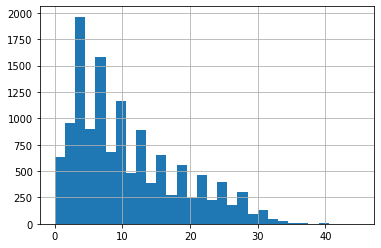

In [ ]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_df['clean_tweet_str']]
pd.Series(seq_len).hist(bins = 30)

In [ ]:
#Count the number of unique words
from collections import Counter
results = Counter()
train_df['clean_tweet_str'].str.lower().str.split().apply(results.update)
print(len(results.keys()))

13821


In [ ]:
#Vectorizing the training data
#https://stackoverflow.com/questions/45735070/keras-text-preprocessing-saving-tokenizer-object-to-file-for-scoring
def vectorizing(trainX_df, testX_df, experiment_dfX, category):
  MAX_NUM_WORDS = 13828 # Parameter indicating the number of words we'll put in the dictionary
  MAX_SEQUENCE_LENGTH = 40 # Maximum number of words in a sequence
  tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
  tokenizer.fit_on_texts(trainX_df)
  token_file_name = 'tokenizer_' + category + '.pickle'
  with open(token_file_name, 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
  #Tokenize the training and test data set
  trainX_seq = tokenizer.texts_to_sequences(trainX_df)
  testX_seq = tokenizer.texts_to_sequences(testX_df)
  experimentX_seq = tokenizer.texts_to_sequences(experiment_dfX)

  word_index = tokenizer.word_index
  print('Found %s unique tokens.' % len(word_index))

  #Padding the sequence 
  trainX_seq_trunc = pad_sequences(trainX_seq, maxlen=MAX_SEQUENCE_LENGTH)
  testX_seq_trunc = pad_sequences(testX_seq, maxlen=MAX_SEQUENCE_LENGTH)
  experimentX_seq_trunc = pad_sequences(experimentX_seq, maxlen = MAX_SEQUENCE_LENGTH)
  return trainX_seq_trunc, testX_seq_trunc, experimentX_seq_trunc, word_index

In [ ]:
a_trainX_df.head()

0                        [ask, native, american, take]
1                               [go, home, drunk, url]
2    [amazon, investigating, chinese, employee, sel...
3            [someone, vet, ken, piece, shit, volcano]
4    [obama, wanted, liberal, amp, illegals, move, ...
Name: clean_tweet, dtype: object

In [ ]:
#Generate vectorized matrix for A B and C
vec_a_trainX_df, vec_a_testX_df, vec_a_exp_df, word_index_a = vectorizing(a_trainX_df, a_testX_df, a_experimentX_df, 'a')
vec_b_trainX_df, vec_b_testX_df, vec_b_exp_df, word_index_b = vectorizing(b_trainX_df, b_testX_df, b_experimentX_df,'b')
vec_c_trainX_df, vec_c_testX_df, vec_c_exp_df, word_index_c = vectorizing(c_trainX_df, c_testX_df, c_experimentX_df, 'c')

Found 13821 unique tokens.
Found 8201 unique tokens.
Found 7744 unique tokens.


In [ ]:
a_experimentY_df.unique()

array(['OFF', 'NOT'], dtype=object)

In [ ]:
#Convert the target classes to categoricial  
le = LabelEncoder()
ie_a_trainY_df = le.fit_transform(a_trainY_df)
print(le.classes_)
ie_a_testY_df = le.transform(a_testY_df)
ie_a_exp_y_df = le.transform(a_experimentY_df)
ie_b_trainY_df = le.fit_transform(b_trainY_df)
print(le.classes_)
ie_b_testY_df = le.transform(b_testY_df)
ie_b_exp_y_df = le.transform(b_experimentY_df)
ie_c_trainY_df = le.fit_transform(c_trainY_df)
print(le.classes_)
ie_c_testY_df = le.transform(c_testY_df)
ie_c_exp_y_df = le.transform(c_experimentY_df)

#Convert to One Hot Encoding
oh_a_trainY_df = to_categorical(ie_a_trainY_df)
oh_a_testY_df = to_categorical(ie_a_testY_df)
oh_a_exp_y_df = to_categorical(ie_a_exp_y_df)
oh_b_trainY_df = to_categorical(ie_b_trainY_df)
oh_b_testY_df = to_categorical(ie_b_testY_df)
oh_b_exp_y_df = to_categorical(ie_b_exp_y_df)
oh_c_trainY_df = to_categorical(ie_c_trainY_df)
oh_c_testY_df = to_categorical(ie_c_testY_df)
oh_c_exp_y_df = to_categorical(ie_c_exp_y_df)

['NOT' 'OFF']
['TIN' 'UNT']
['GRP' 'IND' 'OTH']


In [ ]:
le.classes_

array(['GRP', 'IND', 'OTH'], dtype=object)

In [ ]:
oh_a_trainY_df.shape,ie_a_trainY_df.shape

((13240, 2), (13240,))

### Splitting of Validation Data
* For one hot encoding
* For integer encoding

In [ ]:
#Allocate 10% of the training data for validation 
oh_a_trainX_df, oh_a_validX_df, oh_a_trainY_df, oh_a_validY_df = train_test_split(vec_a_trainX_df, oh_a_trainY_df, test_size = 0.1, random_state = 37)
oh_b_trainX_df, oh_b_validX_df, oh_b_trainY_df, oh_b_validY_df = train_test_split(vec_b_trainX_df, oh_b_trainY_df, test_size = 0.1, random_state = 37)
oh_c_trainX_df, oh_c_validX_df, oh_c_trainY_df, oh_c_validY_df = train_test_split(vec_c_trainX_df, oh_c_trainY_df, test_size = 0.1, random_state = 37)

#For Integer Encoding 
le_a_trainX_df, le_a_validX_df, le_a_trainY_df, le_a_validY_df = train_test_split(vec_a_trainX_df, ie_a_trainY_df, test_size = 0.1, random_state = 37)
le_b_trainX_df, le_b_validX_df, le_b_trainY_df, le_b_validY_df = train_test_split(vec_b_trainX_df, ie_b_trainY_df, test_size = 0.1, random_state = 37)
le_c_trainX_df, le_c_validX_df, le_c_trainY_df, le_c_validY_df = train_test_split(vec_c_trainX_df, ie_c_trainY_df, test_size = 0.1, random_state = 37)

In [ ]:
le_a_trainX_df

array([[   0,    0,    0, ..., 3375, 4704,  279],
       [   0,    0,    0, ...,   61,  123, 4393],
       [   0,    0,    0, ...,   30, 1958,  819],
       ...,
       [   0,    0,    0, ..., 3880,  964,   18],
       [   0,    0,    0, ..., 4459, 3456,   36],
       [   0,    0,    0, ...,    0,   70, 3136]], dtype=int32)

# GloVe Init
* For Neural Network 
* For statistical model

## For STATS Model

In [ ]:
#convert the training data to string
a_trainX_str = a_trainX_df.apply(', '.join)
a_testX_str = a_testX_df.apply(', ' .join)
a_expX_str = a_experimentX_df.apply(',' .join)
b_trainX_str = b_trainX_df.apply(', '.join)
b_testX_str = b_testX_df.apply(', '.join)
b_expX_str = b_experimentX_df.apply(',' .join)
c_trainX_str = c_trainX_df.apply(', '.join)
c_testX_str = c_testX_df.apply(', '.join)
c_expX_str = c_experimentX_df.apply(',' .join)

In [ ]:
# #Download the embedding transformer 
# ## TAKES LONG
# glove = EmbeddingTransformer('glove-twitter-200')


In [ ]:
#Embed the training data 
a_trainX_em = glove.transform(a_trainX_str)
a_testX_em = glove.transform(a_testX_str)
a_expX_em = glove.transform(a_expX_str)
b_trainX_em = glove.transform(b_trainX_str)
b_testX_em = glove.transform(b_testX_str)
b_expX_em = glove.transform(b_expX_str)
c_trainX_em = glove.transform(c_trainX_str)
c_testX_em = glove.transform(c_testX_str)
c_expX_em = glove.transform(c_expX_str)

In [ ]:
b_trainX_em.shape, ie_b_trainY_df.shape, b_testX_df.shape, b_testX_em.shape

((4400, 200), (4400,), (240,), (240, 200))

In [ ]:
# Create Validation Split
a_trainX_em, a_validX_em, a_trainY_em, a_validY_em = train_test_split(a_trainX_em, ie_a_trainY_df, test_size=0.1, random_state=37)
b_trainX_em, b_validX_em, b_trainY_em, b_validY_em = train_test_split(b_trainX_em, ie_b_trainY_df, test_size=0.1, random_state=37)
c_trainX_em, c_validX_em, c_trainY_em, c_validY_em = train_test_split(c_trainX_em, ie_c_trainY_df, test_size=0.1, random_state=37)

### Test the Model's Performance 

AUC is:  0.5950740436034554
              precision    recall  f1-score   support

           0       0.74      0.67      0.70       884
           1       0.44      0.52      0.48       440

    accuracy                           0.62      1324
   macro avg       0.59      0.60      0.59      1324
weighted avg       0.64      0.62      0.63      1324

Confusion Matrix: 
 [[590 294]
 [210 230]]


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


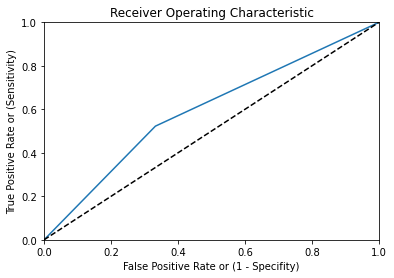

In [ ]:
# Balanced Weights
# LOGISTIC REGRESSION
from sklearn.metrics import classification_report, confusion_matrix

model = LogisticRegression(max_iter=100000, class_weight='balanced', solver='newton-cg')
model.fit(a_trainX_em, a_trainY_em)

y_pred = model.predict(a_validX_em)

evaluate_on_training_set(a_validY_em, y_pred)

AUC is:  0.5701754385964912
              precision    recall  f1-score   support

           0       0.93      0.67      0.78       402
           1       0.12      0.47      0.19        38

    accuracy                           0.65       440
   macro avg       0.52      0.57      0.48       440
weighted avg       0.86      0.65      0.73       440

Confusion Matrix: 
 [[268 134]
 [ 20  18]]


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


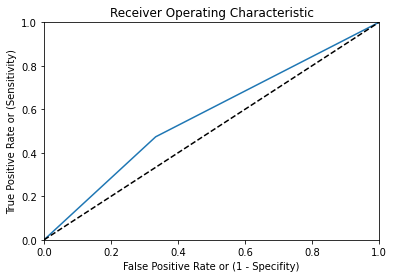

In [ ]:

# Balanced Weights
# LOGISTIC REGRESSION

model = LogisticRegression(max_iter=100000, class_weight='balanced', solver='newton-cg')
model.fit(b_trainX_em, b_trainY_em)

y_pred = model.predict(b_validX_em)

evaluate_on_training_set(b_validY_em, y_pred)

In [ ]:
# Balanced Weights
# LOGISTIC REGRESSION
from sklearn.metrics import classification_report, confusion_matrix

model = LogisticRegression(max_iter=100000, class_weight='balanced', solver='newton-cg', multi_class='ovr')
model.fit(c_trainX_em, c_trainY_em)

y_pred = model.predict(c_validX_em)

classification_report = classification_report(c_validY_em, y_pred)

print('\n Accuracy: ', accuracy_score(c_validY_em, y_pred))
print('\nClassification Report')
print('======================================================')
print('\n', classification_report)

print(f"AUC score:{multiclass_roc_auc_score(c_validY_em, y_pred)}")

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')



 Accuracy:  0.4639175257731959

Classification Report

               precision    recall  f1-score   support

           0       0.33      0.36      0.34        97
           1       0.76      0.49      0.59       261
           2       0.16      0.60      0.25        30

    accuracy                           0.46       388
   macro avg       0.41      0.48      0.40       388
weighted avg       0.60      0.46      0.50       388

AUC score:0.602072909339398


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


#Data Cleaning Intermediate

## Load the DataFrames

In [ ]:
#read the files into their respective dataframes 
labela_df = pd.read_csv('/content/drive/My Drive/CDS_Project/OLIDv1/labels-levela.csv', header = None)
labelb_df = pd.read_csv('/content/drive/My Drive/CDS_Project/OLIDv1/labels-levelb.csv', header = None)
labelc_df = pd.read_csv('/content/drive/My Drive/CDS_Project/OLIDv1/labels-levelc.csv', header = None)
testa_df = pd.read_csv('/content/drive/My Drive/CDS_Project/OLIDv1/testset-levela.tsv', sep = '\t')
testb_df = pd.read_csv('/content/drive/My Drive/CDS_Project/OLIDv1/testset-levelb.tsv', sep = '\t')
testc_df = pd.read_csv('/content/drive/My Drive/CDS_Project/OLIDv1/testset-levelc.tsv', sep = '\t')
train_df = pd.read_csv('/content/drive/My Drive/CDS_Project/OLIDv1/olid-training-v1.0.tsv', sep = '\t')
experiment_df = pd.read_excel('/content/drive/My Drive/CDS_Project/OLIDv1/Data/PublicData.xlsx')

In [ ]:
#Clean the experimental labels 
experiment_df['subtask_a'] = experiment_df['subtask_a'].replace('OFF ', 'OFF')
experiment_df['subtask_b'] = experiment_df['subtask_b'].replace('OFF ', 'OFF')
experiment_df['subtask_c'] = experiment_df['subtask_c'].replace('OFF ', 'OFF')
experiment_df['subtask_a'].unique(),experiment_df['subtask_b'].unique(), experiment_df['subtask_c'].unique() 

(array(['OFF', 'NOT'], dtype=object),
 array(['TIN', nan, 'UNT'], dtype=object),
 array(['IND', 'GRP', 'OTH', nan], dtype=object))

In [ ]:
#Split the experiment data into A, B and C
experiment_a_df = experiment_df[['tweet', 'subtask_a']]
experiment_b_df = experiment_df[['tweet', 'subtask_b']]
experiment_c_df = experiment_df[['tweet', 'subtask_c']]
experiment_a_df.head()

,tweet,subtask_a
0,RT @iSellGreenCards: 1st RT @MsSashaBelle: Sho...,OFF
1,@40oz_VAN IYCMI. I can't get any work done if ...,OFF
2,&#8220;@lildebo2391: He too rich to let that b...,OFF
3,Really Barnicle? OJ or Anthony Weiner? MJ is a...,OFF
4,RT @GabrielaAngela4: That hoe wanta 6/6.,OFF


In [ ]:
#Merge the label dataset with the test data set, so only Test data set needed

testa_df['subtask_a'] = labela_df[1]
testb_df['subtask_b'] = labelb_df[1]
testc_df['subtask_c'] = labelc_df[1]
testc_df.head()

,id,tweet,subtask_c
0,15923,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...,OTH
1,60133,#NoPasaran: Unity demo to oppose the far-right...,GRP
2,83681,. . . What the fuck did he do this time?,IND
3,65507,@USER Do you get the feeling he is kissing @US...,OTH
4,34263,#StopKavanaugh he is liar like the rest of the...,IND


In [ ]:
#View the training data set
train_df.head()

,id,tweet,subtask_a,subtask_b,subtask_c
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN


## Cleaning the Tweets

The training and test data are in 2 separate files, so a function has been written to to tidy the text up and return a column of cleaned tweets

* remove URLs, Hashtags, Mentions, Reserved Words (RT, FAV), Emojis
* Change text to lowercase 
* Handle Apostrophe (e.g. aren't -> are not)
* Remove punctuations
* Remove numbers 
* Segment the words (fix the spelling) 
* Lemmatization and Tokenization
* Remove Stop Words (with Blacklist and Whitelist words)

### Cleaning Function

In [ ]:
#list of contractions to remove later 
contractions = {
"ain't": "am not / are not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is",
"i'd": "I had / I would",
"i'd've": "I would have",
"i'll": "I shall / I will",
"i'll've": "I shall have / I will have",
"i'm": "I am",
"i've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

In [ ]:
#Setting up SymSpell to segment words
sym_spell = SymSpell(max_dictionary_edit_distance=0, prefix_length=7)
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt")
# term_index is the column of the term and count_index is the column of the term frequency
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)


True

In [ ]:
#Setting up Lematizer, Tokenizer
lemmatizer = nltk.stem.WordNetLemmatizer()
w_tokenizer = TweetTokenizer()

In [ ]:
#Removes specially chosen stop words
def cleaner(row, contractions, blacklist, whitelist):
  '''
  Blacklist: Words that are not in stop words but we will be removing 
  Whitelist: Words that are in the stop words but we will be keeping
  '''
  #remove URLs, Hashtags, Mentions, Reserved Words (RT, FAV), Emojis
  row = p.clean(row)
  #lower the text 
  row = row.lower()
  #Apostrophe Handling
  for word in row.split():
    if word in contractions: 
      row = row.replace(word, contractions[word.lower()])
  #remove punctuations
  row  = "".join([char for char in row if char not in string.punctuation])
  row = re.sub('[0-9]+', '', row, flags=re.MULTILINE)
  #remove numbers 
  row = re.sub(r'\d+', '', row, flags=re.MULTILINE)
  #Segment the words 
  try:
    row = (sym_spell.word_segmentation(row)).corrected_string
  except: 
    pass
  #Lemmatization and Tokenization
  row = [(lemmatizer.lemmatize(w)) for w in w_tokenizer.tokenize((row))]
  #Stopwords 
  all_stopwords = stopwords.words('english')
  all_stopwords.extend(blacklist)
  all_stopwords = set(all_stopwords)- set(whitelist)
  row = [word for word in row if word not in all_stopwords]
  return row

In [ ]:
tqdm.pandas()
#List of stopwords that want to remove in addition to the ones in stopwords corpus
badboy_list = ['url', 'ha']
#List of stopwords that we would like to keep 
goodboy_list = [ ]
#Apply modified clean tweet to the training data
train_df['clean_tweet'] = train_df['tweet'].progress_apply(lambda x: cleaner(x, contractions, badboy_list, goodboy_list))
#Apply modified clean tweet to the test data
testc_df['clean_tweet'] = testc_df['tweet'].progress_apply(lambda x: cleaner(x, contractions, badboy_list, goodboy_list))
testb_df['clean_tweet'] = testb_df['tweet'].progress_apply(lambda x: cleaner(x, contractions, badboy_list, goodboy_list))
testa_df['clean_tweet'] = testa_df['tweet'].progress_apply(lambda x: cleaner(x, contractions, badboy_list, goodboy_list))
#Apply modified cleaen tweet to the experimental data 
experiment_a_df['clean_tweet'] = experiment_a_df['tweet'].progress_apply(lambda x: cleaner(x, contractions, badboy_list, goodboy_list))
experiment_b_df['clean_tweet'] = experiment_b_df['tweet'].progress_apply(lambda x: cleaner(x, contractions, badboy_list, goodboy_list))
experiment_c_df['clean_tweet'] = experiment_c_df['tweet'].progress_apply(lambda x: cleaner(x, contractions, badboy_list, goodboy_list))

100%|██████████| 200/200 [00:01<00:00, 183.11it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
100%|██████████| 200/200 [00:01<00:00, 183.31it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
100%|██████████| 200/200 [00:01<00:00, 182.08it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on

In [ ]:
experiment_a_df.head()

,tweet,subtask_a,clean_tweet
0,RT @iSellGreenCards: 1st RT @MsSashaBelle: Sho...,OFF,"[st, rt, show, proof, sold, pussy, I, shall, I..."
1,@40oz_VAN IYCMI. I can't get any work done if ...,OFF,"[iycmi, get, work, done, keep, show, bitch]"
2,&#8220;@lildebo2391: He too rich to let that b...,OFF,"[rich, let, bitch, get, mad, like, nigga, think]"
3,Really Barnicle? OJ or Anthony Weiner? MJ is a...,OFF,"[really, barn, cleo, j, anthony, er, mj, clown..."
4,RT @GabrielaAngela4: That hoe wanta 6/6.,OFF,"[hoe, want]"


In [ ]:
#Train Dataframe for each of the subsets  
train_df_a = train_df.dropna(subset=['subtask_a'])
train_df_a = train_df_a.drop(columns = ['subtask_b', 'subtask_c'])
train_df_b = train_df.dropna(subset=['subtask_b'])
train_df_b = train_df_b.drop(columns = ['subtask_a', 'subtask_c'])
train_df_c = train_df.dropna(subset=['subtask_c'])
train_df_c = train_df_c.drop(columns = ['subtask_a', 'subtask_b'])
experiment_a_df = experiment_a_df.dropna(subset=['subtask_a']) 
experiment_b_df = experiment_b_df.dropna(subset=['subtask_b'])
experiment_c_df = experiment_c_df.dropna(subset=['subtask_c'])

In [ ]:
experiment_a_df['subtask_a'].unique(), experiment_b_df['subtask_b'].unique(), experiment_c_df['subtask_c'].unique()

(array(['OFF', 'NOT'], dtype=object),
 array(['TIN', 'UNT'], dtype=object),
 array(['IND', 'GRP', 'OTH'], dtype=object))

Key Dataframes 

In [ ]:
#Split the data into X and Y 
#Split the data into X and Y
a_trainX_df = train_df_a['clean_tweet']
a_trainY_df = train_df_a['subtask_a'] 
a_testX_df = testa_df['clean_tweet'] 
a_testY_df = testa_df['subtask_a'] 
a_experimentX_df = experiment_a_df['clean_tweet']
a_experimentY_df = experiment_a_df['subtask_a']

b_trainX_df = train_df_b['clean_tweet']
b_trainY_df = train_df_b['subtask_b'] 
b_testX_df = testb_df['clean_tweet'] 
b_testY_df = testb_df['subtask_b'] 
b_experimentX_df = experiment_b_df['clean_tweet']
b_experimentY_df = experiment_b_df['subtask_b']


c_trainX_df = train_df_c['clean_tweet']
c_trainY_df = train_df_c['subtask_c'] 
c_testX_df = testc_df['clean_tweet'] 
c_testY_df = testc_df['subtask_c'] 
c_experimentX_df = experiment_c_df['clean_tweet']
c_experimentY_df = experiment_c_df['subtask_c']

## Vectorizing the Tweets

In [ ]:
#Convert list to string
train_df['clean_tweet_str'] = train_df['clean_tweet'].apply(lambda x: ' '.join([str(elem) for elem in x]))

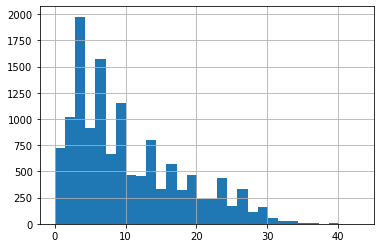

In [ ]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_df['clean_tweet_str']]
pd.Series(seq_len).hist(bins = 30)

In [ ]:
#Count the number of unique words
from collections import Counter
results = Counter()
train_df['clean_tweet_str'].str.lower().str.split().apply(results.update)
print(len(results.keys()))

13819


In [ ]:
#Vectorizing the training data
#https://stackoverflow.com/questions/45735070/keras-text-preprocessing-saving-tokenizer-object-to-file-for-scoring
def vectorizing(trainX_df, testX_df, experiment_dfX, category):
  MAX_NUM_WORDS = 13828 # Parameter indicating the number of words we'll put in the dictionary
  MAX_SEQUENCE_LENGTH = 40 # Maximum number of words in a sequence
  tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
  tokenizer.fit_on_texts(trainX_df)
  token_file_name = 'tokenizer_' + category + '.pickle'
  with open(token_file_name, 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
  #Tokenize the training and test data set
  trainX_seq = tokenizer.texts_to_sequences(trainX_df)
  testX_seq = tokenizer.texts_to_sequences(testX_df)
  experimentX_seq = tokenizer.texts_to_sequences(experiment_dfX)

  word_index = tokenizer.word_index
  print('Found %s unique tokens.' % len(word_index))

  #Padding the sequence 
  trainX_seq_trunc = pad_sequences(trainX_seq, maxlen=MAX_SEQUENCE_LENGTH)
  testX_seq_trunc = pad_sequences(testX_seq, maxlen=MAX_SEQUENCE_LENGTH)
  experimentX_seq_trunc = pad_sequences(experimentX_seq, maxlen = MAX_SEQUENCE_LENGTH)
  return trainX_seq_trunc, testX_seq_trunc, experimentX_seq_trunc, word_index

In [ ]:
a_trainX_df.head()

0                        [ask, native, american, take]
1                                    [go, home, drunk]
2    [amazon, investigating, chinese, employee, sel...
3            [someone, vet, ken, piece, shit, volcano]
4    [obama, wanted, liberal, amp, illegals, move, ...
Name: clean_tweet, dtype: object

In [ ]:
#Generate vectorized matrix for A B and C
vec_a_trainX_df, vec_a_testX_df, vec_a_exp_df, word_index_a = vectorizing(a_trainX_df, a_testX_df, a_experimentX_df, 'a')
vec_b_trainX_df, vec_b_testX_df, vec_b_exp_df, word_index_b = vectorizing(b_trainX_df, b_testX_df, b_experimentX_df,'b')
vec_c_trainX_df, vec_c_testX_df, vec_c_exp_df, word_index_c = vectorizing(c_trainX_df, c_testX_df, c_experimentX_df, 'c')

Found 13819 unique tokens.
Found 8199 unique tokens.
Found 7742 unique tokens.


In [ ]:
a_experimentY_df.unique()

array(['OFF', 'NOT'], dtype=object)

In [ ]:
#Convert the target classes to categoricial  
le = LabelEncoder()
ie_a_trainY_df = le.fit_transform(a_trainY_df)
print(le.classes_)
ie_a_testY_df = le.transform(a_testY_df)
ie_a_exp_y_df = le.transform(a_experimentY_df)
ie_b_trainY_df = le.fit_transform(b_trainY_df)
print(le.classes_)
ie_b_testY_df = le.transform(b_testY_df)
ie_b_exp_y_df = le.transform(b_experimentY_df)
ie_c_trainY_df = le.fit_transform(c_trainY_df)
print(le.classes_)
ie_c_testY_df = le.transform(c_testY_df)
ie_c_exp_y_df = le.transform(c_experimentY_df)

#Convert to One Hot Encoding
oh_a_trainY_df = to_categorical(ie_a_trainY_df)
oh_a_testY_df = to_categorical(ie_a_testY_df)
oh_a_exp_y_df = to_categorical(ie_a_exp_y_df)
oh_b_trainY_df = to_categorical(ie_b_trainY_df)
oh_b_testY_df = to_categorical(ie_b_testY_df)
oh_b_exp_y_df = to_categorical(ie_b_exp_y_df)
oh_c_trainY_df = to_categorical(ie_c_trainY_df)
oh_c_testY_df = to_categorical(ie_c_testY_df)
oh_c_exp_y_df = to_categorical(ie_c_exp_y_df)

['NOT' 'OFF']
['TIN' 'UNT']
['GRP' 'IND' 'OTH']


In [ ]:
le.classes_

array(['GRP', 'IND', 'OTH'], dtype=object)

In [ ]:
oh_a_trainY_df.shape,ie_a_trainY_df.shape

((13240, 2), (13240,))

### Splitting of Validation Data
* For one hot encoding
* For integer encoding

In [ ]:
#Allocate 10% of the training data for validation 
oh_a_trainX_df, oh_a_validX_df, oh_a_trainY_df, oh_a_validY_df = train_test_split(vec_a_trainX_df, oh_a_trainY_df, test_size = 0.1, random_state = 37)
oh_b_trainX_df, oh_b_validX_df, oh_b_trainY_df, oh_b_validY_df = train_test_split(vec_b_trainX_df, oh_b_trainY_df, test_size = 0.1, random_state = 37)
oh_c_trainX_df, oh_c_validX_df, oh_c_trainY_df, oh_c_validY_df = train_test_split(vec_c_trainX_df, oh_c_trainY_df, test_size = 0.1, random_state = 37)

#For Integer Encoding 
le_a_trainX_df, le_a_validX_df, le_a_trainY_df, le_a_validY_df = train_test_split(vec_a_trainX_df, ie_a_trainY_df, test_size = 0.1, random_state = 37)
le_b_trainX_df, le_b_validX_df, le_b_trainY_df, le_b_validY_df = train_test_split(vec_b_trainX_df, ie_b_trainY_df, test_size = 0.1, random_state = 37)
le_c_trainX_df, le_c_validX_df, le_c_trainY_df, le_c_validY_df = train_test_split(vec_c_trainX_df, ie_c_trainY_df, test_size = 0.1, random_state = 37)

In [ ]:
le_a_trainX_df

array([[   0,    0,    0, ..., 3373, 4702,  277],
       [   0,    0,    0, ...,   59,  121, 4391],
       [   0,    0,    0, ...,   28, 1956,  817],
       ...,
       [   0,    0,    0, ..., 3878,  962,   16],
       [   0,    0,    0, ..., 4457, 3454,   34],
       [   0,    0,    0, ...,    0,   68, 3134]], dtype=int32)

# GloVe Intermediate
* For Neural Network 
* For statistical model

## For STATS Model

In [ ]:
#convert the training data to string
a_trainX_str = a_trainX_df.apply(', '.join)
a_testX_str = a_testX_df.apply(', ' .join)
a_expX_str = a_experimentX_df.apply(',' .join)
b_trainX_str = b_trainX_df.apply(', '.join)
b_testX_str = b_testX_df.apply(', '.join)
b_expX_str = b_experimentX_df.apply(',' .join)
c_trainX_str = c_trainX_df.apply(', '.join)
c_testX_str = c_testX_df.apply(', '.join)
c_expX_str = c_experimentX_df.apply(',' .join)

In [ ]:
# #Download the embedding transformer 
# ## TAKES LONG
# glove = EmbeddingTransformer('glove-twitter-200')


In [ ]:
#Embed the training data 
a_trainX_em = glove.transform(a_trainX_str)
a_testX_em = glove.transform(a_testX_str)
a_expX_em = glove.transform(a_expX_str)
b_trainX_em = glove.transform(b_trainX_str)
b_testX_em = glove.transform(b_testX_str)
b_expX_em = glove.transform(b_expX_str)
c_trainX_em = glove.transform(c_trainX_str)
c_testX_em = glove.transform(c_testX_str)
c_expX_em = glove.transform(c_expX_str)

In [ ]:
b_trainX_em.shape, ie_b_trainY_df.shape, b_testX_df.shape, b_testX_em.shape

((4400, 200), (4400,), (240,), (240, 200))

In [ ]:
# Create Validation Split
a_trainX_em, a_validX_em, a_trainY_em, a_validY_em = train_test_split(a_trainX_em, ie_a_trainY_df, test_size=0.1, random_state=37)
b_trainX_em, b_validX_em, b_trainY_em, b_validY_em = train_test_split(b_trainX_em, ie_b_trainY_df, test_size=0.1, random_state=37)
c_trainX_em, c_validX_em, c_trainY_em, c_validY_em = train_test_split(c_trainX_em, ie_c_trainY_df, test_size=0.1, random_state=37)

### Test the Model's Performance 

AUC is:  0.5996452077334431
              precision    recall  f1-score   support

           0       0.74      0.66      0.70       884
           1       0.44      0.54      0.49       440

    accuracy                           0.62      1324
   macro avg       0.59      0.60      0.59      1324
weighted avg       0.64      0.62      0.63      1324

Confusion Matrix: 
 [[580 304]
 [201 239]]


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


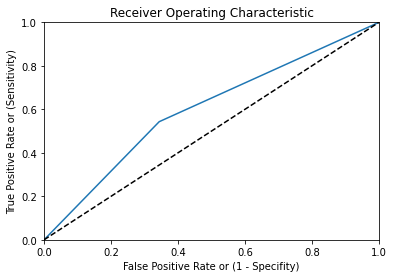

In [ ]:
# Balanced Weights
# LOGISTIC REGRESSION
from sklearn.metrics import classification_report, confusion_matrix

model = LogisticRegression(max_iter=100000, class_weight='balanced', solver='newton-cg')
model.fit(a_trainX_em, a_trainY_em)

y_pred = model.predict(a_validX_em)

evaluate_on_training_set(a_validY_em, y_pred)

AUC is:  0.5314218381775334
              precision    recall  f1-score   support

           0       0.92      0.64      0.76       402
           1       0.10      0.42      0.16        38

    accuracy                           0.62       440
   macro avg       0.51      0.53      0.46       440
weighted avg       0.85      0.62      0.71       440

Confusion Matrix: 
 [[258 144]
 [ 22  16]]


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


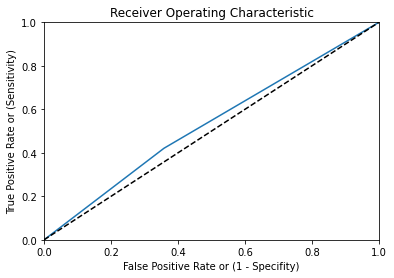

In [ ]:
# Balanced Weights
# LOGISTIC REGRESSION

model = LogisticRegression(max_iter=100000, class_weight='balanced', solver='newton-cg')
model.fit(b_trainX_em, b_trainY_em)

y_pred = model.predict(b_validX_em)

evaluate_on_training_set(b_validY_em, y_pred)

In [ ]:
# Balanced Weights
# LOGISTIC REGRESSION
from sklearn.metrics import classification_report, confusion_matrix

model = LogisticRegression(max_iter=100000, class_weight='balanced', solver='newton-cg', multi_class='ovr')
model.fit(c_trainX_em, c_trainY_em)

y_pred = model.predict(c_validX_em)

classification_report = classification_report(c_validY_em, y_pred)

print('\n Accuracy: ', accuracy_score(c_validY_em, y_pred))
print('\nClassification Report')
print('======================================================')
print('\n', classification_report)

print(f"AUC score:{multiclass_roc_auc_score(c_validY_em, y_pred)}")

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')



 Accuracy:  0.48711340206185566

Classification Report

               precision    recall  f1-score   support

           0       0.36      0.41      0.38        97
           1       0.75      0.51      0.61       261
           2       0.15      0.50      0.23        30

    accuracy                           0.49       388
   macro avg       0.42      0.48      0.41       388
weighted avg       0.61      0.49      0.52       388

AUC score:0.6000096911602818


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


#Data Cleaning Advanced

## Load the DataFrames

In [ ]:
#read the files into their respective dataframes 
labela_df = pd.read_csv('/content/drive/My Drive/CDS_Project/OLIDv1/labels-levela.csv', header = None)
labelb_df = pd.read_csv('/content/drive/My Drive/CDS_Project/OLIDv1/labels-levelb.csv', header = None)
labelc_df = pd.read_csv('/content/drive/My Drive/CDS_Project/OLIDv1/labels-levelc.csv', header = None)
testa_df = pd.read_csv('/content/drive/My Drive/CDS_Project/OLIDv1/testset-levela.tsv', sep = '\t')
testb_df = pd.read_csv('/content/drive/My Drive/CDS_Project/OLIDv1/testset-levelb.tsv', sep = '\t')
testc_df = pd.read_csv('/content/drive/My Drive/CDS_Project/OLIDv1/testset-levelc.tsv', sep = '\t')
train_df = pd.read_csv('/content/drive/My Drive/CDS_Project/OLIDv1/olid-training-v1.0.tsv', sep = '\t')
experiment_df = pd.read_excel('/content/drive/My Drive/CDS_Project/OLIDv1/Data/PublicData.xlsx')

In [ ]:
#Clean the experimental labels 
experiment_df['subtask_a'] = experiment_df['subtask_a'].replace('OFF ', 'OFF')
experiment_df['subtask_b'] = experiment_df['subtask_b'].replace('OFF ', 'OFF')
experiment_df['subtask_c'] = experiment_df['subtask_c'].replace('OFF ', 'OFF')
experiment_df['subtask_a'].unique(),experiment_df['subtask_b'].unique(), experiment_df['subtask_c'].unique() 

(array(['OFF', 'NOT'], dtype=object),
 array(['TIN', nan, 'UNT'], dtype=object),
 array(['IND', 'GRP', 'OTH', nan], dtype=object))

In [ ]:
#Split the experiment data into A, B and C
experiment_a_df = experiment_df[['tweet', 'subtask_a']]
experiment_b_df = experiment_df[['tweet', 'subtask_b']]
experiment_c_df = experiment_df[['tweet', 'subtask_c']]
experiment_a_df.head()

,tweet,subtask_a
0,RT @iSellGreenCards: 1st RT @MsSashaBelle: Sho...,OFF
1,@40oz_VAN IYCMI. I can't get any work done if ...,OFF
2,&#8220;@lildebo2391: He too rich to let that b...,OFF
3,Really Barnicle? OJ or Anthony Weiner? MJ is a...,OFF
4,RT @GabrielaAngela4: That hoe wanta 6/6.,OFF


In [ ]:
#Merge the label dataset with the test data set, so only Test data set needed

testa_df['subtask_a'] = labela_df[1]
testb_df['subtask_b'] = labelb_df[1]
testc_df['subtask_c'] = labelc_df[1]
testc_df.head()

,id,tweet,subtask_c
0,15923,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...,OTH
1,60133,#NoPasaran: Unity demo to oppose the far-right...,GRP
2,83681,. . . What the fuck did he do this time?,IND
3,65507,@USER Do you get the feeling he is kissing @US...,OTH
4,34263,#StopKavanaugh he is liar like the rest of the...,IND


In [ ]:
#View the training data set
train_df.head()

,id,tweet,subtask_a,subtask_b,subtask_c
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN


## Cleaning the Tweets

The training and test data are in 2 separate files, so a function has been written to to tidy the text up and return a column of cleaned tweets

* remove URLs, Hashtags, Mentions, Reserved Words (RT, FAV), Emojis
* Change text to lowercase 
* Handle Apostrophe (e.g. aren't -> are not)
* Remove punctuations
* Remove numbers 
* Segment the words (fix the spelling) 
* Lemmatization and Tokenization
* Remove Stop Words (with Blacklist and Whitelist words)

### Cleaning Function

In [ ]:
#list of contractions to remove later 
contractions = {
"ain't": "am not / are not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is",
"i'd": "I had / I would",
"i'd've": "I would have",
"i'll": "I shall / I will",
"i'll've": "I shall have / I will have",
"i'm": "I am",
"i've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

In [ ]:
#Setting up SymSpell to segment words
sym_spell = SymSpell(max_dictionary_edit_distance=0, prefix_length=7)
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt")
# term_index is the column of the term and count_index is the column of the term frequency
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)


True

In [ ]:
#Setting up Lematizer, Tokenizer
lemmatizer = nltk.stem.WordNetLemmatizer()
w_tokenizer = TweetTokenizer()

In [ ]:
#Removes specially chosen stop words
def cleaner(row, contractions, blacklist, whitelist):
  '''
  Blacklist: Words that are not in stop words but we will be removing 
  Whitelist: Words that are in the stop words but we will be keeping
  '''
  #remove URLs, Hashtags, Mentions, Reserved Words (RT, FAV), Emojis
  row = p.clean(row)
  #lower the text 
  row = row.lower()
  #Apostrophe Handling
  for word in row.split():
    if word in contractions: 
      row = row.replace(word, contractions[word.lower()])
  #remove punctuations
  row  = "".join([char for char in row if char not in string.punctuation])
  row = re.sub('[0-9]+', '', row, flags=re.MULTILINE)
  #remove numbers 
  row = re.sub(r'\d+', '', row, flags=re.MULTILINE)
  #Segment the words 
  try:
    row = (sym_spell.word_segmentation(row)).corrected_string
  except: 
    pass
  #Lemmatization and Tokenization
  row = [(lemmatizer.lemmatize(w)) for w in w_tokenizer.tokenize((row))]
  #Stopwords 
  all_stopwords = stopwords.words('english')
  all_stopwords.extend(blacklist)
  all_stopwords = set(all_stopwords)- set(whitelist)
  row = [word for word in row if word not in all_stopwords]
  return row

In [ ]:
tqdm.pandas()
#List of stopwords that want to remove in addition to the ones in stopwords corpus
badboy_list = []
#List of stopwords that we would like to keep 
goodboy_list = ['i', 'he', 'she', 'it', 'him', 'her', 'we', 'you', 'they', 'us', 'them' ]
#Apply modified clean tweet to the training data
train_df['clean_tweet'] = train_df['tweet'].progress_apply(lambda x: cleaner(x, contractions, badboy_list, goodboy_list))
#Apply modified clean tweet to the test data
testc_df['clean_tweet'] = testc_df['tweet'].progress_apply(lambda x: cleaner(x, contractions, badboy_list, goodboy_list))
testb_df['clean_tweet'] = testb_df['tweet'].progress_apply(lambda x: cleaner(x, contractions, badboy_list, goodboy_list))
testa_df['clean_tweet'] = testa_df['tweet'].progress_apply(lambda x: cleaner(x, contractions, badboy_list, goodboy_list))
#Apply modified cleaen tweet to the experimental data 
experiment_a_df['clean_tweet'] = experiment_a_df['tweet'].progress_apply(lambda x: cleaner(x, contractions, badboy_list, goodboy_list))
experiment_b_df['clean_tweet'] = experiment_b_df['tweet'].progress_apply(lambda x: cleaner(x, contractions, badboy_list, goodboy_list))
experiment_c_df['clean_tweet'] = experiment_c_df['tweet'].progress_apply(lambda x: cleaner(x, contractions, badboy_list, goodboy_list))

100%|██████████| 200/200 [00:01<00:00, 185.09it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
100%|██████████| 200/200 [00:01<00:00, 185.83it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
100%|██████████| 200/200 [00:01<00:00, 182.17it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on

In [ ]:
experiment_a_df.head()

,tweet,subtask_a,clean_tweet
0,RT @iSellGreenCards: 1st RT @MsSashaBelle: Sho...,OFF,"[st, rt, show, proof, i, sold, pussy, I, shall..."
1,@40oz_VAN IYCMI. I can't get any work done if ...,OFF,"[iycmi, i, get, work, done, you, keep, show, b..."
2,&#8220;@lildebo2391: He too rich to let that b...,OFF,"[he, rich, let, bitch, get, him, mad, like, ni..."
3,Really Barnicle? OJ or Anthony Weiner? MJ is a...,OFF,"[really, barn, i, cleo, j, anthony, we, er, mj..."
4,RT @GabrielaAngela4: That hoe wanta 6/6.,OFF,"[hoe, want]"


In [ ]:
#Train Dataframe for each of the subsets  
train_df_a = train_df.dropna(subset=['subtask_a'])
train_df_a = train_df_a.drop(columns = ['subtask_b', 'subtask_c'])
train_df_b = train_df.dropna(subset=['subtask_b'])
train_df_b = train_df_b.drop(columns = ['subtask_a', 'subtask_c'])
train_df_c = train_df.dropna(subset=['subtask_c'])
train_df_c = train_df_c.drop(columns = ['subtask_a', 'subtask_b'])
experiment_a_df = experiment_a_df.dropna(subset=['subtask_a']) 
experiment_b_df = experiment_b_df.dropna(subset=['subtask_b'])
experiment_c_df = experiment_c_df.dropna(subset=['subtask_c'])

In [ ]:
experiment_a_df['subtask_a'].unique(), experiment_b_df['subtask_b'].unique(), experiment_c_df['subtask_c'].unique()

(array(['OFF', 'NOT'], dtype=object),
 array(['TIN', 'UNT'], dtype=object),
 array(['IND', 'GRP', 'OTH'], dtype=object))

Key Dataframes 

In [ ]:
#Split the data into X and Y 
#Split the data into X and Y
a_trainX_df = train_df_a['clean_tweet']
a_trainY_df = train_df_a['subtask_a'] 
a_testX_df = testa_df['clean_tweet'] 
a_testY_df = testa_df['subtask_a'] 
a_experimentX_df = experiment_a_df['clean_tweet']
a_experimentY_df = experiment_a_df['subtask_a']

b_trainX_df = train_df_b['clean_tweet']
b_trainY_df = train_df_b['subtask_b'] 
b_testX_df = testb_df['clean_tweet'] 
b_testY_df = testb_df['subtask_b'] 
b_experimentX_df = experiment_b_df['clean_tweet']
b_experimentY_df = experiment_b_df['subtask_b']


c_trainX_df = train_df_c['clean_tweet']
c_trainY_df = train_df_c['subtask_c'] 
c_testX_df = testc_df['clean_tweet'] 
c_testY_df = testc_df['subtask_c'] 
c_experimentX_df = experiment_c_df['clean_tweet']
c_experimentY_df = experiment_c_df['subtask_c']

## Vectorizing the Tweets

In [ ]:
#Convert list to string
train_df['clean_tweet_str'] = train_df['clean_tweet'].apply(lambda x: ' '.join([str(elem) for elem in x]))

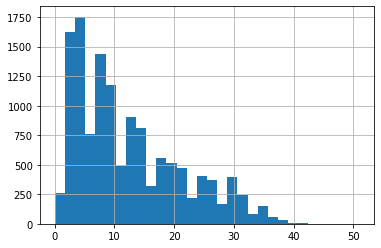

In [ ]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_df['clean_tweet_str']]
pd.Series(seq_len).hist(bins = 30)

In [ ]:
#Count the number of unique words
from collections import Counter
results = Counter()
train_df['clean_tweet_str'].str.lower().str.split().apply(results.update)
print(len(results.keys()))

13830


In [ ]:
#Vectorizing the training data
#https://stackoverflow.com/questions/45735070/keras-text-preprocessing-saving-tokenizer-object-to-file-for-scoring
def vectorizing(trainX_df, testX_df, experiment_dfX, category):
  MAX_NUM_WORDS = 13828 # Parameter indicating the number of words we'll put in the dictionary
  MAX_SEQUENCE_LENGTH = 40 # Maximum number of words in a sequence
  tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
  tokenizer.fit_on_texts(trainX_df)
  token_file_name = 'tokenizer_' + category + '.pickle'
  with open(token_file_name, 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
  #Tokenize the training and test data set
  trainX_seq = tokenizer.texts_to_sequences(trainX_df)
  testX_seq = tokenizer.texts_to_sequences(testX_df)
  experimentX_seq = tokenizer.texts_to_sequences(experiment_dfX)

  word_index = tokenizer.word_index
  print('Found %s unique tokens.' % len(word_index))

  #Padding the sequence 
  trainX_seq_trunc = pad_sequences(trainX_seq, maxlen=MAX_SEQUENCE_LENGTH)
  testX_seq_trunc = pad_sequences(testX_seq, maxlen=MAX_SEQUENCE_LENGTH)
  experimentX_seq_trunc = pad_sequences(experimentX_seq, maxlen = MAX_SEQUENCE_LENGTH)
  return trainX_seq_trunc, testX_seq_trunc, experimentX_seq_trunc, word_index

In [ ]:
a_trainX_df.head()

0                   [she, ask, native, american, take]
1                          [go, home, you, drunk, url]
2    [amazon, investigating, chinese, employee, sel...
3            [someone, vet, ken, piece, shit, volcano]
4    [obama, wanted, liberal, amp, illegals, move, ...
Name: clean_tweet, dtype: object

In [ ]:
#Generate vectorized matrix for A B and C
vec_a_trainX_df, vec_a_testX_df, vec_a_exp_df, word_index_a = vectorizing(a_trainX_df, a_testX_df, a_experimentX_df, 'a')
vec_b_trainX_df, vec_b_testX_df, vec_b_exp_df, word_index_b = vectorizing(b_trainX_df, b_testX_df, b_experimentX_df,'b')
vec_c_trainX_df, vec_c_testX_df, vec_c_exp_df, word_index_c = vectorizing(c_trainX_df, c_testX_df, c_experimentX_df, 'c')

Found 13830 unique tokens.
Found 8210 unique tokens.
Found 7753 unique tokens.


In [ ]:
a_experimentY_df.unique()

array(['OFF', 'NOT'], dtype=object)

In [ ]:
#Convert the target classes to categoricial  
le = LabelEncoder()
ie_a_trainY_df = le.fit_transform(a_trainY_df)
print(le.classes_)
ie_a_testY_df = le.transform(a_testY_df)
ie_a_exp_y_df = le.transform(a_experimentY_df)
ie_b_trainY_df = le.fit_transform(b_trainY_df)
print(le.classes_)
ie_b_testY_df = le.transform(b_testY_df)
ie_b_exp_y_df = le.transform(b_experimentY_df)
ie_c_trainY_df = le.fit_transform(c_trainY_df)
print(le.classes_)
ie_c_testY_df = le.transform(c_testY_df)
ie_c_exp_y_df = le.transform(c_experimentY_df)

#Convert to One Hot Encoding
oh_a_trainY_df = to_categorical(ie_a_trainY_df)
oh_a_testY_df = to_categorical(ie_a_testY_df)
oh_a_exp_y_df = to_categorical(ie_a_exp_y_df)
oh_b_trainY_df = to_categorical(ie_b_trainY_df)
oh_b_testY_df = to_categorical(ie_b_testY_df)
oh_b_exp_y_df = to_categorical(ie_b_exp_y_df)
oh_c_trainY_df = to_categorical(ie_c_trainY_df)
oh_c_testY_df = to_categorical(ie_c_testY_df)
oh_c_exp_y_df = to_categorical(ie_c_exp_y_df)

['NOT' 'OFF']
['TIN' 'UNT']
['GRP' 'IND' 'OTH']


In [ ]:
le.classes_

array(['GRP', 'IND', 'OTH'], dtype=object)

In [ ]:
oh_a_trainY_df.shape,ie_a_trainY_df.shape

((13240, 2), (13240,))

### Splitting of Validation Data
* For one hot encoding
* For integer encoding

In [ ]:
#Allocate 10% of the training data for validation 
oh_a_trainX_df, oh_a_validX_df, oh_a_trainY_df, oh_a_validY_df = train_test_split(vec_a_trainX_df, oh_a_trainY_df, test_size = 0.1, random_state = 37)
oh_b_trainX_df, oh_b_validX_df, oh_b_trainY_df, oh_b_validY_df = train_test_split(vec_b_trainX_df, oh_b_trainY_df, test_size = 0.1, random_state = 37)
oh_c_trainX_df, oh_c_validX_df, oh_c_trainY_df, oh_c_validY_df = train_test_split(vec_c_trainX_df, oh_c_trainY_df, test_size = 0.1, random_state = 37)

#For Integer Encoding 
le_a_trainX_df, le_a_validX_df, le_a_trainY_df, le_a_validY_df = train_test_split(vec_a_trainX_df, ie_a_trainY_df, test_size = 0.1, random_state = 37)
le_b_trainX_df, le_b_validX_df, le_b_trainY_df, le_b_validY_df = train_test_split(vec_b_trainX_df, ie_b_trainY_df, test_size = 0.1, random_state = 37)
le_c_trainX_df, le_c_validX_df, le_c_trainY_df, le_c_validY_df = train_test_split(vec_c_trainX_df, ie_c_trainY_df, test_size = 0.1, random_state = 37)

In [ ]:
le_a_trainX_df

array([[   0,    0,    0, ..., 3384, 4713,  288],
       [   0,    0,    0, ...,   70,  132, 4402],
       [   0,    0,    0, ...,   39, 1967,  828],
       ...,
       [   0,    0,    0, ...,  973,   26,    3],
       [   0,    0,    0, ..., 4468, 3465,   45],
       [   0,    0,    0, ...,    0,   79, 3145]], dtype=int32)

# GloVe Advanced
* For Neural Network 
* For statistical model

## For STATS Model

In [ ]:
#convert the training data to string
a_trainX_str = a_trainX_df.apply(', '.join)
a_testX_str = a_testX_df.apply(', ' .join)
a_expX_str = a_experimentX_df.apply(',' .join)
b_trainX_str = b_trainX_df.apply(', '.join)
b_testX_str = b_testX_df.apply(', '.join)
b_expX_str = b_experimentX_df.apply(',' .join)
c_trainX_str = c_trainX_df.apply(', '.join)
c_testX_str = c_testX_df.apply(', '.join)
c_expX_str = c_experimentX_df.apply(',' .join)

In [ ]:
# #Download the embedding transformer 
# ## TAKES LONG
# glove = EmbeddingTransformer('glove-twitter-200')


In [ ]:
#Embed the training data 
a_trainX_em = glove.transform(a_trainX_str)
a_testX_em = glove.transform(a_testX_str)
a_expX_em = glove.transform(a_expX_str)
b_trainX_em = glove.transform(b_trainX_str)
b_testX_em = glove.transform(b_testX_str)
b_expX_em = glove.transform(b_expX_str)
c_trainX_em = glove.transform(c_trainX_str)
c_testX_em = glove.transform(c_testX_str)
c_expX_em = glove.transform(c_expX_str)

In [ ]:
b_trainX_em.shape, ie_b_trainY_df.shape, b_testX_df.shape, b_testX_em.shape

((4400, 200), (4400,), (240,), (240, 200))

In [ ]:
# Create Validation Split
a_trainX_em, a_validX_em, a_trainY_em, a_validY_em = train_test_split(a_trainX_em, ie_a_trainY_df, test_size=0.1, random_state=37)
b_trainX_em, b_validX_em, b_trainY_em, b_validY_em = train_test_split(b_trainX_em, ie_b_trainY_df, test_size=0.1, random_state=37)
c_trainX_em, c_validX_em, c_trainY_em, c_validY_em = train_test_split(c_trainX_em, ie_c_trainY_df, test_size=0.1, random_state=37)

### Test the Model's Performance 

AUC is:  0.5905234471410942
              precision    recall  f1-score   support

           0       0.73      0.67      0.70       884
           1       0.44      0.51      0.47       440

    accuracy                           0.62      1324
   macro avg       0.58      0.59      0.59      1324
weighted avg       0.63      0.62      0.62      1324

Confusion Matrix: 
 [[592 292]
 [215 225]]


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


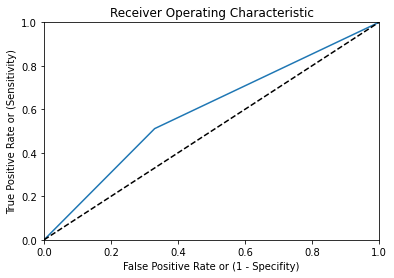

In [ ]:
# Balanced Weights
# LOGISTIC REGRESSION
from sklearn.metrics import classification_report, confusion_matrix

model = LogisticRegression(max_iter=100000, class_weight='balanced', solver='newton-cg')
model.fit(a_trainX_em, a_trainY_em)

y_pred = model.predict(a_validX_em)

evaluate_on_training_set(a_validY_em, y_pred)

AUC is:  0.5607488871432312
              precision    recall  f1-score   support

           0       0.93      0.67      0.78       402
           1       0.11      0.45      0.18        38

    accuracy                           0.65       440
   macro avg       0.52      0.56      0.48       440
weighted avg       0.86      0.65      0.73       440

Confusion Matrix: 
 [[271 131]
 [ 21  17]]


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


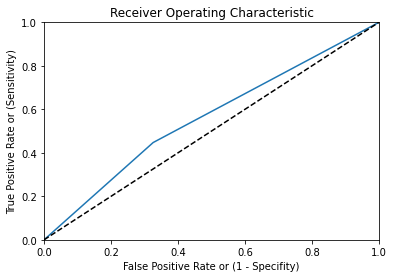

In [ ]:
# Balanced Weights
# LOGISTIC REGRESSION

model = LogisticRegression(max_iter=100000, class_weight='balanced', solver='newton-cg')
model.fit(b_trainX_em, b_trainY_em)

y_pred = model.predict(b_validX_em)

evaluate_on_training_set(b_validY_em, y_pred)

In [ ]:
# Balanced Weights
# LOGISTIC REGRESSION
from sklearn.metrics import classification_report, confusion_matrix

model = LogisticRegression(max_iter=100000, class_weight='balanced', solver='newton-cg', multi_class='ovr')
model.fit(c_trainX_em, c_trainY_em)

y_pred = model.predict(c_validX_em)

classification_report = classification_report(c_validY_em, y_pred)

print('\n Accuracy: ', accuracy_score(c_validY_em, y_pred))
print('\nClassification Report')
print('======================================================')
print('\n', classification_report)

print(f"AUC score:{multiclass_roc_auc_score(c_validY_em, y_pred)}")

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')



 Accuracy:  0.47164948453608246

Classification Report

               precision    recall  f1-score   support

           0       0.34      0.35      0.35        97
           1       0.76      0.51      0.61       261
           2       0.14      0.53      0.23        30

    accuracy                           0.47       388
   macro avg       0.41      0.46      0.39       388
weighted avg       0.60      0.47      0.51       388

AUC score:0.593314019309077


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
